# Patterns of Concern: California's Health Disparities

Data Sources used:

Health Dataset  https://chronicdata.cdc.gov/500-Cities/500-Cities-Census-Tract-level-Data-GIS-FriendlyFo/k86t-wghb  

Pollution Dataset https://oehha.ca.gov/calenviroscreen/maps-data/download-data 

Socioeconomics Dataset https://svi.cdc.gov/data-and-tools-download.html 

Better Doctor API https://developer.betterdoctor.com/documentation15 

# PART 1: Exploring Health Disparities

In [2]:
#!conda install -c conda-forge --yes plotnine
#!conda install -c conda-forge --yes geopandas

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\ProgramData\Anaconda3

  added / updated specs:
    - plotnine


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2019.11.28 |       hecc5488_0         182 KB  conda-forge
    certifi-2019.11.28         |           py37_0         148 KB  conda-forge
    mizani-0.6.0               |             py_0          52 KB  conda-forge
    openssl-1.1.1d             |       hfa6e2cd_0         4.7 MB  conda-forge
    plotnine-0.6.0             |             py_0         3.3 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         8.4 MB

The following NEW packages will be INSTALLED:

  descartes          conda-forge/noarch::descartes-1.1.0-py_4
  mizani             conda-forge/noarch::mizani-0.6.0-py_0
  palettable  

In [13]:
# Part 1: Exploring Health Disparities

import numpy as np
import pandas as pd
import json

%matplotlib inline

import matplotlib.pyplot as plt
from plotnine import *

from scipy.stats import linregress
import seaborn as sns

# Part 2: Doctor Prevalence

import geopandas as gpd
import shapely as shape
import geopy.distance as gpy #install -c conda-forge geopy

import requests
import requests_cache
from random import randint
from time import sleep
requests_cache.install_cache("mycache")
pd.options.mode.chained_assignment = None  # default='warn'

ImportError: cannot import name 'CRS' from 'pyproj' (C:\ProgramData\Anaconda3\lib\site-packages\pyproj\__init__.py)

# Cleaning the data

In [12]:
#Choose CA for health dataset
health = pd.read_csv('500_Cities__Census_Tract-level_Data__GIS_Friendly_Format___2018_release.csv')
health = health[health['StateAbbr'] == 'CA']

In [13]:
#Get the information we need
health_needed = health[['Place_TractID','PlaceName','BPHIGH_CrudePrev','CASTHMA_CrudePrev','COPD_CrudePrev',
           'CSMOKING_CrudePrev','DIABETES_CrudePrev','HIGHCHOL_CrudePrev','MHLTH_CrudePrev','SLEEP_CrudePrev']]

#Get the population weight for each disease percentage.
population_total = health[['PlaceName','Population2010']]
population_total= population_total.groupby(['PlaceName']).sum().reset_index()
population_total = population_total.rename(columns = {population_total.columns[1]: "Total Population"})
population_each = health[['Place_TractID','PlaceName','Population2010']]
population_proportion = pd.merge(population_each,population_total , on = 'PlaceName')
population_proportion['Population weight'] = population_proportion['Population2010']/population_proportion['Total Population']
population_weight = population_proportion[['Place_TractID','Population weight']]
health_needed = pd.merge(health_needed,population_weight , on = 'Place_TractID')

In [14]:
#Get the weighted average of each disease
for i in range(8):
    health_needed.iloc[:,i+2] = health_needed.iloc[:,i+2]*health_needed.iloc[:,10]
health_needed = health_needed.iloc[:,1:10]
health_needed= health_needed.groupby(['PlaceName']).sum().reset_index()

In [15]:
#Read the pollution dataset
pollution = pd.read_excel('ces3results.xlsx',sheet_name='CES 3.0 (2018 Update)')

In [16]:
#Choose the information we need and get the mean of each pollution for each city.
pollution_needed = pollution[['Nearby City \n(to help approximate location only)',
                             'CES 3.0 Score','Ozone','PM2.5','Diesel PM','Drinking Water',
                              'Pesticides','Tox. Release','Traffic','Haz. Waste',
                              'Imp. Water Bodies','Solid Waste','Pollution Burden Score']]
pollution_needed = pollution_needed.rename(columns = {pollution_needed.columns[0]: "PlaceName"})
pollution_needed = pollution_needed.groupby(['PlaceName']).mean().reset_index()

In [17]:
#This dataset is the dataset of disease and pollution
information = pd.merge(health_needed, pollution_needed, on = 'PlaceName')

In [18]:
#Read the socioeconomics dataset
socioeconomics = pd.read_csv("California.csv")

In [19]:
#Choose the information we need 
socioeconomics = socioeconomics[["FIPS","E_PCI","EP_NOHSDP"]]

#delete null cells
socioeconomics = socioeconomics[socioeconomics["E_PCI"]!=-999.0]
socioeconomics = socioeconomics[socioeconomics["EP_NOHSDP"]!=0.0]

#get the mean of each socioeconomical factors for each city.
health_for_socio = health[["PlaceName","TractFIPS"]]
socioeconomics = pd.merge(health_for_socio, socioeconomics, left_on = "TractFIPS", right_on = "FIPS")
socioeconomics = socioeconomics.groupby(["PlaceName"]).mean().reset_index()
socioeconomics = socioeconomics.drop(columns = ["TractFIPS","FIPS"])

In [20]:
#This dataset is the dataset of disease and socioeconomics
information = pd.merge(information, socioeconomics, on = "PlaceName")

# Get five cities with highest disease rate and lowest disease rate

In [30]:
#Get disease rate of asthma and COPD
asthma = information.sort_values('CASTHMA_CrudePrev')

COPD = information.sort_values('COPD_CrudePrev')

In [31]:
#get cities that both have low disease rate of of asthma and COPD
list(set(asthma.head(8)['PlaceName']).intersection(COPD.head(8)['PlaceName']))

['Milpitas', 'Fremont', 'Santa Clara', 'San Ramon', 'Sunnyvale']

In [32]:
#get cities that both have high disease rate of of asthma and COPD
list(set(asthma.tail(10)['PlaceName']).intersection(COPD.tail(11)['PlaceName']))

['Apple Valley', 'San Bernardino', 'Victorville', 'Citrus Heights', 'Hesperia']

In [33]:
#get cities that both have high disease rate of diabetes
Diabetes = information.sort_values('DIABETES_CrudePrev')

In [34]:
#get cities that both have low disease rate of of Diabetes
list(Diabetes.head(5)['PlaceName'])

['Redondo Beach', 'San Ramon', 'Berkeley', 'Folsom', 'Irvine']

In [35]:
#get cities that both have high disease rate of Diabetes
list(Diabetes.tail(5)['PlaceName'])

['Westminster', 'Inglewood', 'San Bernardino', 'Compton', 'Hemet']

In [36]:
#Get disease rate of mental health
mental_health = information.sort_values('MHLTH_CrudePrev')

In [37]:
#get cities that have low disease rate of mental health
list(mental_health.head(5)['PlaceName'])

['San Ramon', 'Sunnyvale', 'Newport Beach', 'Fremont', 'Milpitas']

In [38]:
#get cities that have high disease rate of mental health
list(mental_health.tail(5)['PlaceName'])

['Hesperia', 'Merced', 'Compton', 'Lynwood', 'San Bernardino']

In [39]:
#Get the high risk and low risk areas for asthma and COPD
asthma_and_COPD = information[information['PlaceName'].isin(['Milpitas', 'Fremont', 'Santa Clara', 'San Ramon', 'Sunnyvale',
                                                            'Apple Valley', 'Hesperia', 'San Bernardino', 
                                                             'Citrus Heights', 'Victorville'])][['CASTHMA_CrudePrev','COPD_CrudePrev','PlaceName']]
asthma_and_COPD = asthma_and_COPD.rename(columns = {asthma_and_COPD.columns[0]: "asthma",
                                                    asthma_and_COPD.columns[1]: "COPD"})

#Stack and clean the data
asthma_and_COPD = asthma_and_COPD.set_index(['PlaceName'])
stacked = asthma_and_COPD .stack()
stacked.index.set_names('disease type', level=len(stacked.index.names)-1, inplace=True)
asthma_and_COPD = stacked.reset_index()
asthma_and_COPD = asthma_and_COPD.rename(columns = {asthma_and_COPD.columns[2]: "percentage"})


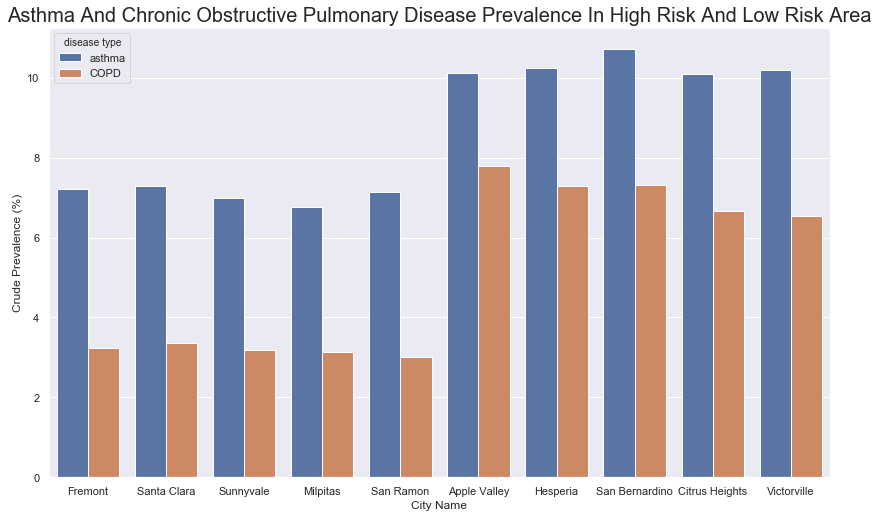

In [41]:
sns.set(rc={'figure.figsize':(14,8.27)})
p8 = sns.barplot(data = asthma_and_COPD, x = "PlaceName", y="percentage", hue = 'disease type',
                 order = ['Fremont', 'Santa Clara', 'Sunnyvale', 'Milpitas', 'San Ramon',
                                                            'Apple Valley', 'Hesperia', 'San Bernardino', 
                                                             'Citrus Heights', 'Victorville'])
p8.set_title('Asthma And Chronic Obstructive Pulmonary Disease Prevalence In High Risk And Low Risk Areas',fontsize = 20)
p8.set_xlabel("City Name")
p8.set_ylabel('Crude Prevalence (%)')
fig8 = p8.get_figure()
fig8.savefig('asthma_and_COPD diabetes.png')

In [42]:
#Get the high risk and low risk areas for Diabetes
Diabetes = information[information['PlaceName'].isin(['Redondo Beach', 'San Ramon', 'Berkeley', 'Folsom', 'Irvine',
                                                            'Westminster', 'Inglewood', 'San Bernardino', 
                                                             'Compton', 'Hemet' ])][['DIABETES_CrudePrev','PlaceName']]

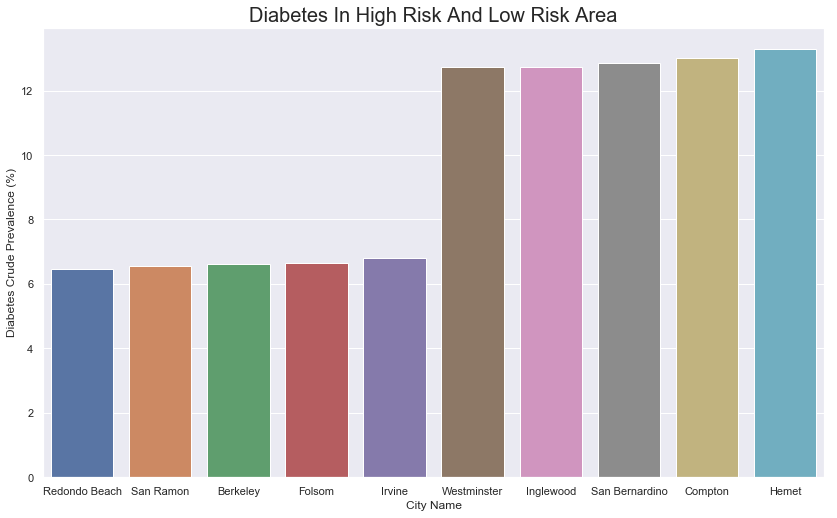

In [43]:
sns.set(rc={'figure.figsize':(14,8.27)})
p8 = sns.barplot(data = Diabetes, x = "PlaceName", y="DIABETES_CrudePrev",
                 order = ['Redondo Beach', 'San Ramon', 'Berkeley', 'Folsom', 'Irvine',
                                                            'Westminster', 'Inglewood', 'San Bernardino', 
                                                             'Compton', 'Hemet' ])
p8.set_title('Diabetes In High Risk And Low Risk Area',fontsize = 20)
p8.set_xlabel("City Name")
p8.set_ylabel('Diabetes Crude Prevalence (%)')
fig8 = p8.get_figure()
fig8.savefig('diabetes.png')

In [44]:
#Get the high risk and low risk area of mental health problem
mental = information[information['PlaceName'].isin(['San Ramon', 'Sunnyvale', 'Newport Beach', 'Fremont', 'Milpitas',
                         'Hesperia', 'Merced', 'Compton', 'Lynwood', 'San Bernardino'])][['MHLTH_CrudePrev','PlaceName']]

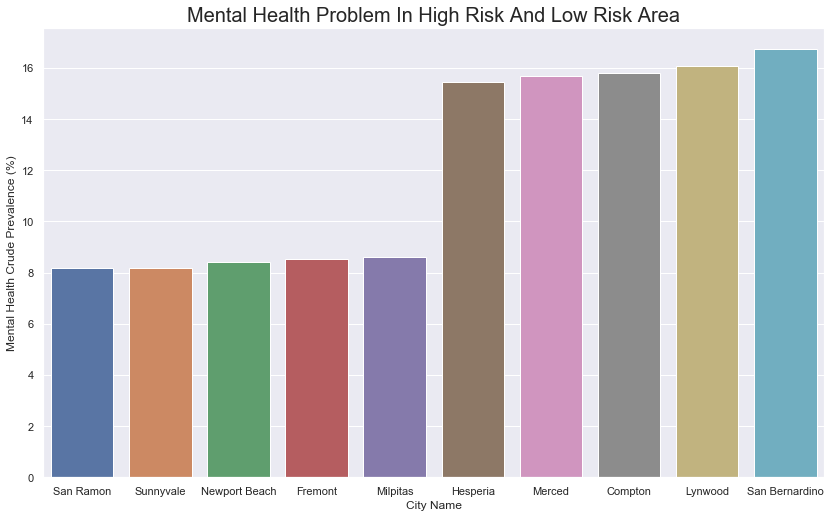

In [45]:
sns.set(rc={'figure.figsize':(14,8.27)})
p8 = sns.barplot(data = mental, x = "PlaceName", y="MHLTH_CrudePrev",
                 order = ['San Ramon', 'Sunnyvale', 'Newport Beach', 'Fremont', 'Milpitas',
                         'Hesperia', 'Merced', 'Compton', 'Lynwood', 'San Bernardino'])
p8.set_title('Mental Health Problem In High Risk And Low Risk Area',fontsize = 20)
p8.set_xlabel("City Name")
p8.set_ylabel('Mental Health Crude Prevalence (%)')
fig8 = p8.get_figure()
fig8.savefig('mental health.png')

# Relationship between pollution and disease

In [46]:
#Relation between the pollution and asthma
linregress(information['CASTHMA_CrudePrev'],information['CES 3.0 Score'])

LinregressResult(slope=5.4462562329864745, intercept=-18.97459540605058, rvalue=0.38967966751109845, pvalue=1.0862981988729268e-05, stderr=1.1849106180749382)

In [47]:
linregress(information['CASTHMA_CrudePrev'],information['Ozone'])

LinregressResult(slope=0.0046769677673804836, intercept=0.00752935498130608, rvalue=0.38025042865045516, pvalue=1.83652475959281e-05, stderr=0.0010472267418643493)

In [48]:
linregress(information['CASTHMA_CrudePrev'],information['PM2.5'])

LinregressResult(slope=-0.0009654859265285544, intercept=10.342271029296366, rvalue=-0.0003464951319688204, pvalue=0.9970032046227674, stderr=0.2565120553052778)

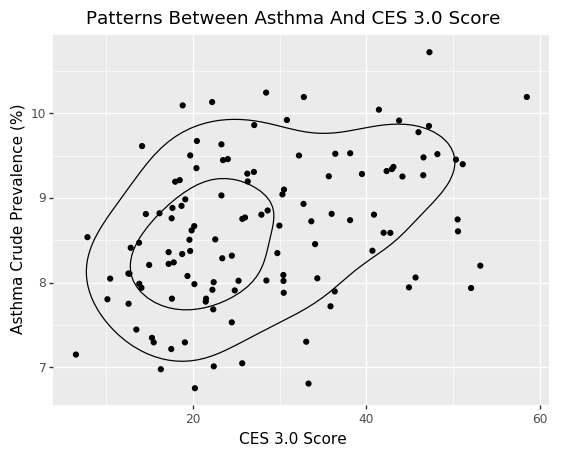

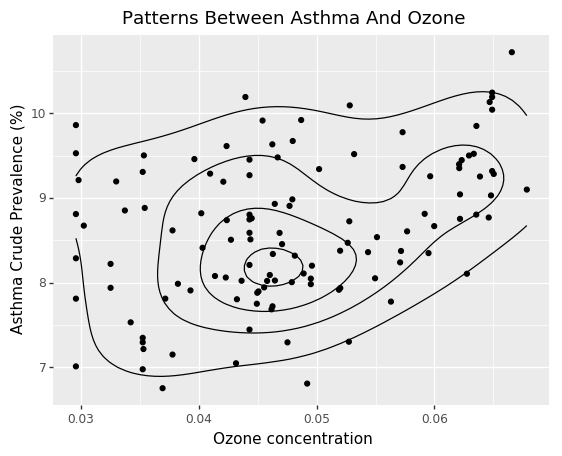

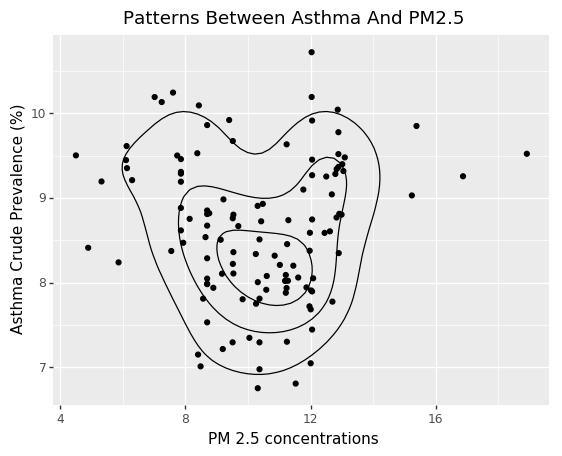

(<ggplot: (7555868911)>,
 <ggplot: (7556752283)>,
 <ggplot: (-9223372029298460430)>)

In [50]:
p1 = (ggplot(information,aes(x = 'CES 3.0 Score',y = 'CASTHMA_CrudePrev')) + geom_point()+ geom_density_2d()
+labs(title = 'Patterns Between Asthma And CES 3.0 Score',y = 'Asthma Crude Prevalence (%)'))
p2 = (ggplot(information,aes(x = 'Ozone',y = 'CASTHMA_CrudePrev')) + geom_point()+ geom_density_2d()
+labs(title = 'Patterns Between Asthma And Ozone',y = 'Asthma Crude Prevalence (%)',x =  'Ozone concentration' ))
p3 = (ggplot(information,aes(x = 'PM2.5',y = 'CASTHMA_CrudePrev')) + geom_point()+ geom_density_2d()
+labs(title = 'Patterns Between Asthma And PM2.5',y = 'Asthma Crude Prevalence (%)',x = 'PM 2.5 concentrations'))
p1,p2,p3

In [51]:
#Relation between the pollution and COPD
linregress(information['COPD_CrudePrev'],information['CES 3.0 Score'])

LinregressResult(slope=4.328161078807903, intercept=5.722570647058909, rvalue=0.3814637617689805, pvalue=1.7180826306938232e-05, stderr=0.9655203847724598)

In [52]:
linregress(information['COPD_CrudePrev'],information['Ozone'])

LinregressResult(slope=0.004238906831388672, intercept=0.02605077096627891, rvalue=0.4245212188454567, pvalue=1.3496481274624327e-06, stderr=0.0008322668256384322)

In [53]:
linregress(information['COPD_CrudePrev'],information['PM2.5'])

LinregressResult(slope=-0.027096783091186474, intercept=10.473410467976567, rvalue=-0.011978684337075166, pvalue=0.8966842384098985, stderr=0.20822671620062858)

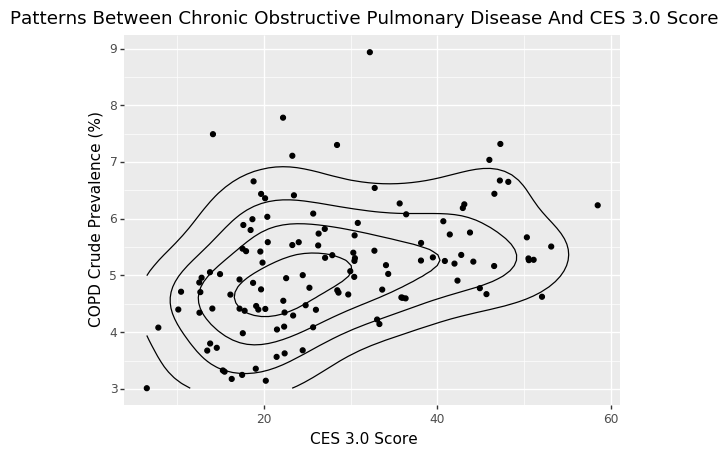

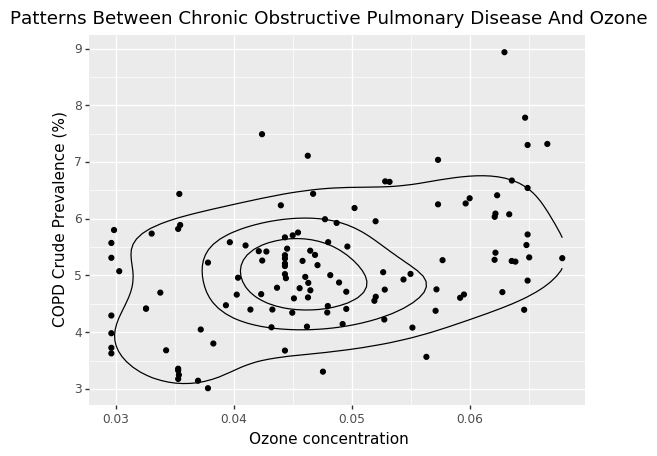

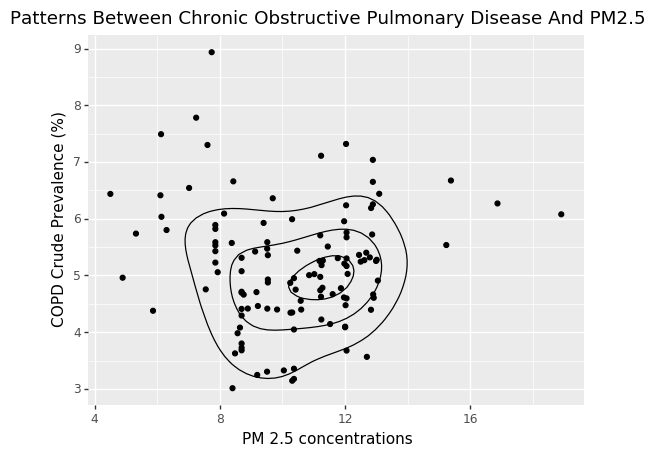

(<ggplot: (-9223372029294360551)>,
 <ggplot: (-9223372029298456923)>,
 <ggplot: (7560547732)>)

In [54]:
p4 = (ggplot(information,aes(x = 'CES 3.0 Score',y = 'COPD_CrudePrev')) + geom_point()+ geom_density_2d()
+labs(title = 'Patterns Between Chronic Obstructive Pulmonary Disease And CES 3.0 Score',y = 'COPD Crude Prevalence (%)'))
p5 = (ggplot(information,aes(x = 'Ozone',y = 'COPD_CrudePrev')) + geom_point()+ geom_density_2d()
+labs(title = 'Patterns Between Chronic Obstructive Pulmonary Disease And Ozone',y = 'COPD Crude Prevalence (%)',x =  'Ozone concentration' ))
p6 = (ggplot(information,aes(x = 'PM2.5',y = 'COPD_CrudePrev')) + geom_point()+ geom_density_2d()
+labs(title = 'Patterns Between Chronic Obstructive Pulmonary Disease And PM2.5',y = 'COPD Crude Prevalence (%)',x = 'PM 2.5 concentrations'))
p4,p5,p6

# Relationship between diabetes and socioeconomics

In [55]:
#Relation between the income per capita and diabetes
linregress(information['DIABETES_CrudePrev'],information['E_PCI'])

LinregressResult(slope=-5782.322020646145, intercept=86290.78546763734, rvalue=-0.7644274130792761, pvalue=3.0492223884673797e-24, stderr=448.9410225756734)

In [56]:
#Relation between the percentage of people with no high school diploma and diabetes
linregress(information['DIABETES_CrudePrev'],information['EP_NOHSDP'])

LinregressResult(slope=4.85505984985268, intercept=-28.49007694272722, rvalue=0.7807437509280549, pvalue=7.446171202358348e-26, stderr=0.35770233245221467)

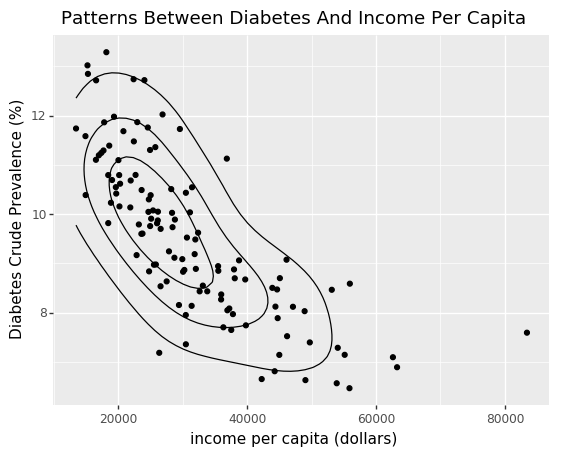

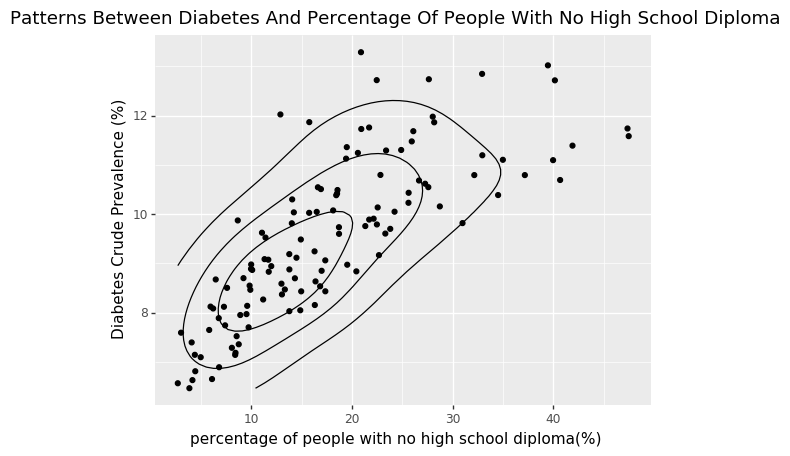

(<ggplot: (-9223372029297665897)>, <ggplot: (7557075709)>)

In [63]:
p7 = (ggplot(information,aes(x = 'E_PCI',y = 'DIABETES_CrudePrev')) + geom_point()+ geom_density_2d()
+labs(title = 'Patterns Between Diabetes And Income Per Capita',
      x = "income per capita (dollars)", y = 'Diabetes Crude Prevalence (%)'))
p8 = (ggplot(information,aes(x = 'EP_NOHSDP',y = 'DIABETES_CrudePrev')) + geom_point()+ geom_density_2d()
+labs(title = 'Patterns Between Diabetes And Percentage Of People With No High School Diploma',
      x = "percentage of people with no high school diploma(%)",y = 'Diabetes Crude Prevalence (%)'))
p7,p8

In [59]:
#Relation between the income per capita and mental health
linregress(information['MHLTH_CrudePrev'],information['E_PCI'])

LinregressResult(slope=-5044.910750717823, intercept=92105.1262638795, rvalue=-0.8284357638389993, pvalue=1.7340543590621427e-31, stderr=313.98353803162036)

In [60]:
#Relation between the lack of sleep and mental health
linregress(information['MHLTH_CrudePrev'],information['SLEEP_CrudePrev'])

LinregressResult(slope=1.024778032225757, intercept=23.013598108729234, rvalue=0.6691571768067194, pvalue=6.61017377395401e-17, stderr=0.10476594610664672)

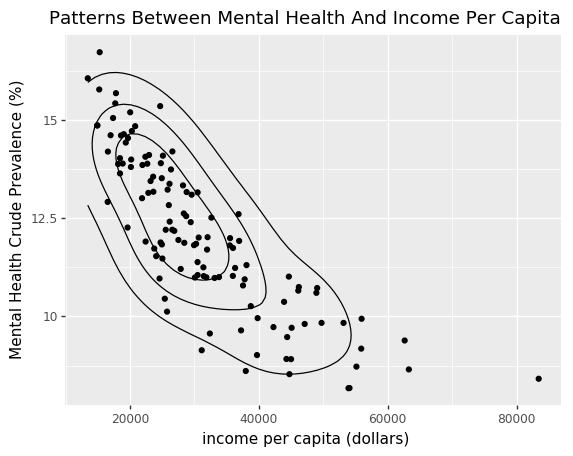

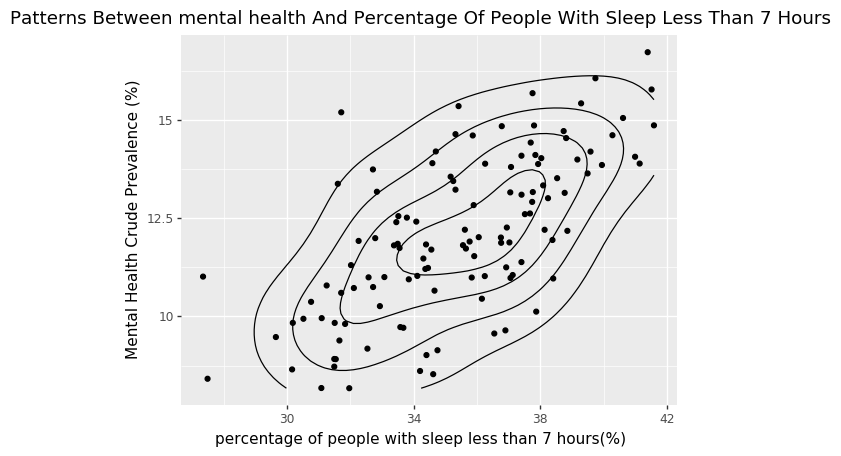

(<ggplot: (7557160936)>, <ggplot: (7556036002)>)

In [66]:
p9 = (ggplot(information,aes(x = 'E_PCI',y = 'MHLTH_CrudePrev')) + geom_point()+ geom_density_2d()
+labs(title = 'Patterns Between Mental Health And Income Per Capita',
      x = "income per capita (dollars)", y = 'Mental Health Crude Prevalence (%)'))
p10 = (ggplot(information,aes(x = 'SLEEP_CrudePrev',y = 'MHLTH_CrudePrev')) + geom_point()+ geom_density_2d()
+labs(title = 'Patterns Between mental health And Percentage Of People With Sleep Less Than 7 Hours',
      x = "percentage of people with sleep less than 7 hours(%)",y = 'Mental Health Crude Prevalence (%)'))
p9,p10

# PART 2: Exploring Doctor Prevalence

# Find # of doctors for highest and lowest risk cities for diabetes and mental health. 

In [71]:
#Choose CA for health dataset
health = pd.read_csv('500_Cities__Census_Tract-level_Data__GIS_Friendly_Format___2018_release.csv')
health = health[health['StateAbbr'] == 'CA']
health.head()

,StateAbbr,PlaceName,PlaceFIPS,TractFIPS,Place_TractID,Population2010,ACCESS2_CrudePrev,ACCESS2_Crude95CI,ARTHRITIS_CrudePrev,ARTHRITIS_Crude95CI,...,PAPTEST_Crude95CI,PHLTH_CrudePrev,PHLTH_Crude95CI,SLEEP_CrudePrev,SLEEP_Crude95CI,STROKE_CrudePrev,STROKE_Crude95CI,TEETHLOST_CrudePrev,TEETHLOST_Crude95CI,Geolocation
1123,CA,Pomona,658072,6037402404,0658072-06037402404,536,8.7,"( 7.4, 10.1)",2.2,"( 2.0, 2.3)",...,"(69.4, 76.7)",3.7,"( 3.3, 4.0)",32.1,"(30.4, 33.3)",0.2,"( 0.2, 0.2)",NaN,NaN,"(34.05974227270, -117.809721958)"
1134,CA,San Diego,666000,6073009901,0666000-06073009901,626,20.8,"(15.7, 24.5)",6.7,"( 6.1, 7.4)",...,"(77.4, 82.4)",11.9,"( 9.7, 13.4)",38.4,"(34.4, 41.4)",1.5,"( 1.3, 1.8)",NaN,NaN,"(32.68867248600, -117.245739866)"
1525,CA,Alameda,600562,6001427100,0600562-06001427100,3646,5.9,"( 4.8, 7.2)",21.9,"(20.7, 23.2)",...,"(82.0, 86.3)",9.6,"( 8.5, 10.9)",31.1,"(29.8, 32.5)",2.5,"( 2.2, 2.9)",6.9,"( 4.2, 11.7)","(37.76456251660, -122.231170131)"
1526,CA,Alameda,600562,6001427200,0600562-06001427200,4107,8.5,"( 7.4, 9.8)",18.0,"(17.1, 18.8)",...,"(78.9, 83.0)",10.1,"( 9.2, 11.1)",35.6,"(34.4, 36.8)",2.3,"( 2.1, 2.5)",8.7,"( 6.1, 11.8)","(37.77592983200, -122.247776936)"
1527,CA,Alameda,600562,6001427300,0600562-06001427300,4896,8.3,"( 7.0, 9.7)",21.4,"(20.3, 22.5)",...,"(78.3, 82.8)",10.9,"( 9.8, 12.2)",34.4,"(33.2, 35.6)",2.8,"( 2.5, 3.2)",9.6,"( 6.4, 13.6)","(37.78119162680, -122.266079332)"


In [72]:
z = health['Population2010'].reset_index()

In [73]:
#Get the information we need
health_needed = health[['Place_TractID','PlaceName','BPHIGH_CrudePrev','CASTHMA_CrudePrev','COPD_CrudePrev',
           'CSMOKING_CrudePrev','DIABETES_CrudePrev','HIGHCHOL_CrudePrev','MHLTH_CrudePrev','SLEEP_CrudePrev']]

#Get the population weight for each disease percentage.
population_total = health[['PlaceName','Population2010']]
population_total= population_total.groupby(['PlaceName']).sum().reset_index()
population_total = population_total.rename(columns = {population_total.columns[1]: "Total Population"})
population_each = health[['Place_TractID','PlaceName','Population2010']]
population_proportion = pd.merge(population_each,population_total , on = 'PlaceName')
population_proportion['Population weight'] = population_proportion['Population2010']/population_proportion['Total Population']
population_weight = population_proportion[['Place_TractID','Population weight']]
health_needed = pd.merge(health_needed,population_weight , on = 'Place_TractID')

In [74]:
#Get the weighted average of each disease
for i in range(8):
    health_needed.iloc[:,i+2] = health_needed.iloc[:,i+2]*health_needed.iloc[:,10]

health_needed = health_needed.iloc[:,1:10]
health_needed['Population2010'] = z.Population2010
health_needed.head()
cityhealthcp= health_needed.groupby(['PlaceName']).sum().reset_index()

In [75]:
#Get the information we need
healthcp = health[['TractFIPS','PlaceName','DIABETES_CrudePrev','MHLTH_CrudePrev','SLEEP_CrudePrev', 'Population2010']]

In [76]:
#get cities that have high disease rate of diabetes
Diabetes = cityhealthcp.sort_values('DIABETES_CrudePrev')

In [78]:
#get cities that have low disease rate of of Diabetes
list(Diabetes.head(5)['PlaceName'])

['Redondo Beach', 'San Ramon', 'Berkeley', 'Folsom', 'Irvine']

In [79]:
#get cities that both have high disease rate of Diabetes
list(Diabetes.tail(5)['PlaceName'])

['Westminster', 'Inglewood', 'San Bernardino', 'Compton', 'Hemet']

In [80]:
#Get disease rate of mental health
mental_health = cityhealthcp.sort_values('MHLTH_CrudePrev')

In [81]:
#get cities that have low disease rate of mental health
list(mental_health.head(5)['PlaceName'])

['San Ramon', 'Sunnyvale', 'Newport Beach', 'Fremont', 'Milpitas']

In [82]:
#get cities that have high disease rate of mental health
list(mental_health.tail(5)['PlaceName'])

['Hesperia', 'Merced', 'Compton', 'Lynwood', 'San Bernardino']

Get # of doctors per city.

In [83]:
key = "a9ed2c27d2f8d4bd41631bf9922c9e82"
def find_numdoc(city):
    response = requests.get("https://api.betterdoctor.com/2016-03-01/doctors", params = {
        "location": city,
        "user_key": key
    })
    sleep(randint(0,2))
    response.raise_for_status()
    result = response.json()
    return result['meta']['total']

In [84]:
cityhealthcp['nameforapi'] = 'ca-'+ cityhealthcp['PlaceName']
doc1 = pd.DataFrame()
doc1['city'] = None

doc2 = pd.DataFrame()
doc2['city'] = None

doc3 = pd.DataFrame()
doc3['city'] = None

#betterdoctor api allows only 40 requests every minute, so we separate the cities into blocks of 40 or less
for i in range(0, 40):
    doc1.loc[i,'city'] = cityhealthcp['nameforapi'][i].lower()
    doc1.loc[i,'city'] = doc1.loc[i,'city'].replace(" ",'-')
    
for i in range(40,81):
    doc2.loc[i,'city'] = cityhealthcp['nameforapi'][i].lower()
    doc2.loc[i,'city'] = doc2.loc[i,'city'].replace(" ",'-')

for i in range(81,121):
    doc3.loc[i,'city'] = cityhealthcp['nameforapi'][i].lower()
    doc3.loc[i,'city'] = doc3.loc[i,'city'].replace(" ",'-')

In [85]:
doc3.loc[86, 'city'] = 'ca-ventura'

In [86]:
doc1['#doctors'] = None
doc1['#doctors'] = list(map(find_numdoc, doc1['city']))

In [87]:
doc2['#doctors'] = None
doc2['#doctors'] = list(map(find_numdoc, doc2['city']))

In [88]:
doc3['#doctors'] = None
doc3['#doctors'] = list(map(find_numdoc, doc3['city']))

In [89]:
doc = pd.concat([doc1, doc2, doc3])
doc['docs/1000'] = None
doc['docs/1000'] = doc['#doctors'] / cityhealthcp['Population2010']*1000


In [90]:
cityhealthcp.head()

,PlaceName,BPHIGH_CrudePrev,CASTHMA_CrudePrev,COPD_CrudePrev,CSMOKING_CrudePrev,DIABETES_CrudePrev,HIGHCHOL_CrudePrev,MHLTH_CrudePrev,SLEEP_CrudePrev,Population2010,nameforapi
0,Alameda,25.719995,8.287716,4.293206,11.752798,8.699557,31.329903,9.712316,33.674755,73812,ca-Alameda
1,Alhambra,27.658207,6.809047,4.142895,11.141932,11.359463,35.362469,10.124007,37.873608,83089,ca-Alhambra
2,Anaheim,25.141230,8.455059,5.181492,14.364481,10.049011,33.324204,12.417236,34.083483,336229,ca-Anaheim
3,Antioch,27.395956,9.286676,5.529028,15.701846,9.813560,33.088785,12.837886,35.896695,102372,ca-Antioch
4,Apple Valley,33.963456,10.131809,7.781888,17.060563,11.867038,38.248907,14.115668,37.846322,69103,ca-Apple Valley


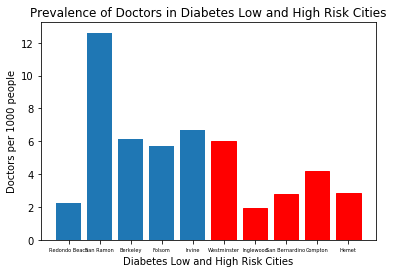

In [91]:
cities = ('ca-redondo-beach', 'ca-san-ramon','ca-berkeley', 
          'ca-folsom', 'ca-irvine','ca-westminster', 'ca-inglewood', 
          'ca-san-bernardino', 'ca-compton', 'ca-hemet')

hilow = doc.loc[doc['city'].isin(cities)]

#num = pd.DataFrame()
#num['city'] = cities
#num = num.set_index('city')
hilow = hilow.set_index('city')
hilow = hilow.reindex(['ca-redondo-beach', 'ca-san-ramon','ca-berkeley', 
          'ca-folsom', 'ca-irvine','ca-westminster', 'ca-inglewood', 
          'ca-san-bernardino', 'ca-compton', 'ca-hemet'])
hilow
#num = pd.DataFrame()
#num['doc/1000'] = pd.DataFrame(list(map(find_numdoc, cities))/)
#num['city'] = ('Irvine', 'Redondo Beach', 'Murrieta', 'Chino Hills',
              #'San Ramon', 'El Monte', 'Rialto', 'Inglewood', 'Hemet',
               #'Compton')

index = np.arange(10)
b = plt.bar(index, hilow['docs/1000'])
plt.xlabel('Diabetes Low and High Risk Cities')
plt.ylabel('Doctors per 1000 people')
plt.xticks(index, ('Redondo Beach', 'San Ramon', 'Berkeley', 'Folsom', 'Irvine',
                   'Westminster', 'Inglewood', 'San Bernardino',
                   'Compton', 'Hemet'), fontsize = 5)
plt.title('Prevalence of Doctors in Diabetes Low and High Risk Cities')
b[5].set_color('r')
b[6].set_color('r')
b[7].set_color('r')
b[8].set_color('r')
b[9].set_color('r')
plt.savefig('g1.png')

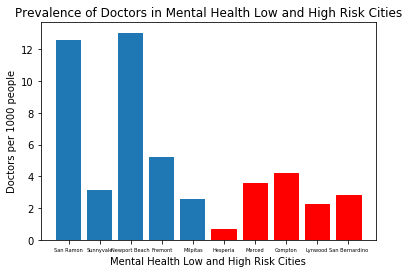

In [92]:
cities = ('ca-san-ramon', 'ca-sunnyvale', 'ca-newport-beach', 'ca-fremont', 
          'ca-milpitas', 'ca-hesperia', 'ca-merced', 'ca-compton', 'ca-lynwood',
          'ca-san-bernardino')

hilow = doc.loc[doc['city'].isin(cities)]

#num = pd.DataFrame()
#num['city'] = cities
#num = num.set_index('city')
hilow = hilow.set_index('city')
hilow = hilow.reindex(['ca-san-ramon', 'ca-sunnyvale', 'ca-newport-beach', 'ca-fremont', 
          'ca-milpitas', 'ca-hesperia', 'ca-merced', 'ca-compton', 'ca-lynwood',
          'ca-san-bernardino'])
hilow
#num = pd.DataFrame()
#num['doc/1000'] = pd.DataFrame(list(map(find_numdoc, cities))/)
#num['city'] = ('Irvine', 'Redondo Beach', 'Murrieta', 'Chino Hills',
              #'San Ramon', 'El Monte', 'Rialto', 'Inglewood', 'Hemet',
               #'Compton')

index = np.arange(10)
b = plt.bar(index, hilow['docs/1000'])
plt.xlabel('Mental Health Low and High Risk Cities')
plt.ylabel('Doctors per 1000 people')
plt.xticks(index, ('San Ramon', 'Sunnyvale', 'Newport Beach', 'Fremont',
                   'Milpitas', 'Hesperia', 'Merced', 'Compton', 'Lynwood',
                   'San Bernardino'), fontsize = 5)
plt.title('Prevalence of Doctors in Mental Health Low and High Risk Cities')
b[5].set_color('r')
b[6].set_color('r')
b[7].set_color('r')
b[8].set_color('r')
b[9].set_color('r')
plt.savefig('g2.png')

plot relationship between doctors and diabetes for all cities

In [93]:
doc['PlaceName'] = cityhealthcp['PlaceName']
health_doc = pd.merge(cityhealthcp, doc, left_on = "PlaceName", right_on = "PlaceName")

In [124]:
diabvdoc = ggplot(health_doc, aes(x = "docs/1000", y = "DIABETES_CrudePrev")) +geom_point() + geom_density_2d() + labs(title = 'Doctor Prevalence vs. Diabetes Risk for Cities', x = 'Doctors per 1000 people', y = 'Crude Prevalence of Diabetes')
diabvdoc
ggsave(diabvdoc, 'g3.png')

C:\Users\Admin\Anaconda3\lib\site-packages\plotnine\ggplot.py:706: UserWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units))
C:\Users\Admin\Anaconda3\lib\site-packages\plotnine\ggplot.py:707: UserWarning: Filename: g3.png
  warn('Filename: {}'.format(filename))


In [125]:
mhvdoc = ggplot(health_doc, aes(x = "docs/1000", y = "MHLTH_CrudePrev"))+geom_point() + geom_density_2d() + labs(title = 'Doctor Prevalence vs. Poor Mental Health Risk for Cities', x = 'Doctors per 1000 people', y = 'Crude Prevalence of Poor Mental Health')
ggsave(mhvdoc, 'g4.png')

C:\Users\Admin\Anaconda3\lib\site-packages\plotnine\ggplot.py:706: UserWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units))
C:\Users\Admin\Anaconda3\lib\site-packages\plotnine\ggplot.py:707: UserWarning: Filename: g4.png
  warn('Filename: {}'.format(filename))


# Find relationship between doctors within radius and disease rate

In [99]:
tracts = gpd.read_file("C:/Users/Admin/OneDrive/Winter 19 Classes/STA 141B/projdata/ca_cities_shape/Cities2015.shp")
tracts.head()

,NAME,CityType,Pop2010,Land_sqmi,DateIncorp,WebLink,County,Notes,CityAbbv,geometry
0,Benicia,City,26997,12.93,1850-03-27,http://www.ci.benicia.ca.us,Solano,None,Ben,POLYGON ((-122.1950206756592 38.06052589416504...
1,Vallejo,City,115942,30.67,1868-03-30,http://www.ci.vallejo.ca.us,Solano,None,Val,(POLYGON ((-122.1957340240479 38.1534748077392...
2,Rio Vista,City,7360,6.69,1894-01-06,http://www.ci.rio-vista.ca.us,Solano,None,RVs,"POLYGON ((-121.6857225265765 38.1586633935685,..."
3,Colusa,City,5971,1.83,1868-06-16,http://www.colusa-ca.gov,Colusa,06-15-007,Clu,"(POLYGON ((-122.02676701273 39.18156497656737,..."
4,Williams,City,5123,5.44,1920-05-17,http://www.cityofwilliams.org,Colusa,None,Wms,POLYGON ((-122.1325376417235 39.16569829375753...


In [100]:
#social vulnerability index data from 2016
svi = gpd.read_file("SVI2016_US.shp")

In [101]:
#we want to join svi data and health data at census tract level
#rename svi tract column to match column name in health
svi.rename(columns={'FIPS': 'TractFIPS'}, inplace=True)
#convert tract column to int64 type to match type in health 
svi['TractFIPS'] = svi['TractFIPS'].astype(np.int64)

In [102]:
#create new dataset from merged svi and health data
healthsvi = healthcp.merge(svi, on='TractFIPS', how='inner')
healthsvi.head()

,TractFIPS,PlaceName,DIABETES_CrudePrev,MHLTH_CrudePrev,SLEEP_CrudePrev,Population2010,ST,STATE,ST_ABBR,STCNTY,...,F_NOVEH,F_GROUPQ,F_THEME4,F_TOTAL,E_UNINSUR,M_UNINSUR,EP_UNINSUR,MP_UNINSUR,E_DAYPOP,geometry
0,6037402404,Pomona,0.8,12.0,32.1,536,06,CALIFORNIA,CA,06037,...,0.0,1.0,1.0,3.0,155.0,67.0,7.7,3.0,30162.0,"POLYGON ((-117.834298 34.05135600000006, -117...."
1,6073009901,San Diego,3.9,21.3,38.4,626,06,CALIFORNIA,CA,06073,...,0.0,1.0,1.0,2.0,0.0,12.0,0.0,71.9,1212.0,POLYGON ((-117.2558590039999 32.70752264300006...
2,6001427100,Alameda,8.5,9.1,31.1,3646,06,CALIFORNIA,CA,06001,...,0.0,0.0,0.0,0.0,165.0,71.0,4.8,2.1,3269.0,"POLYGON ((-122.238101 37.76977900000003, -122...."
3,6001427200,Alameda,9.3,10.8,35.6,4107,06,CALIFORNIA,CA,06001,...,0.0,0.0,0.0,0.0,396.0,184.0,9.6,4.3,4187.0,"POLYGON ((-122.257832 37.77603700000003, -122...."
4,6001427300,Alameda,10.6,10.3,34.4,4896,06,CALIFORNIA,CA,06001,...,0.0,0.0,0.0,1.0,758.0,324.0,14.1,5.8,5664.0,"POLYGON ((-122.27671 37.77719200000007, -122.2..."


In [103]:
d = ('San Bernardino', 'Compton', 'Hemet')
b = ('Compton', 'Lynwood', 'San Bernardino')
worst3diab = healthsvi.loc[healthsvi['PlaceName'].isin(d)].reset_index()
worst3mh = healthsvi.loc[healthsvi['PlaceName'].isin(b)].reset_index()

In [104]:
#find radius of a tract
def find_radius(fips):
    shape = tuple(svi.loc[svi['TractFIPS']==fips].geometry)[0]
    center = tuple(shape.centroid.coords)[0]
    # reverse (lon,lat) to (lat,lon)
    center = center[::-1]
    #create dataframe to store radiuses
    r = pd.DataFrame()
    r['rad'] = None
    #find max between center and all boundary points
    for i in range(0, len(tuple(shape.boundary.coords))):        
        bounds = tuple(shape.boundary.coords)[i]
        bounds = bounds[::-1]
        r.loc[i, 'rad'] = gpy.distance(center, bounds)
    #convert from km to miles
    radius = max(r.rad)
    convers_factor = 0.621371
    radius =  radius * convers_factor
    return radius

In [105]:
find_radius(6037543100)

Distance(0.9072218364655207)

In [106]:
#get radius of census tracts for 3 cities with highest risk of diabetes
worst3diab['radius1'] = None
worst3diab['radius5'] = None
worst3diab['radius10'] = None
for i in range(0,len(worst3diab.TractFIPS)):
    try:
        worst3diab.radius1[i] = str(float(str(find_radius(worst3diab.TractFIPS[i])).replace('km',''))+1)
        worst3diab.radius5[i] = str(float(str(find_radius(worst3diab.TractFIPS[i])).replace('km',''))+5)
        worst3diab.radius10[i] = str(float(str(find_radius(worst3diab.TractFIPS[i])).replace('km',''))+10)
    except NotImplementedError:
        continue


In [107]:
#get radii of tracts in 3 highest risk cities for poor mental health
worst3mh['radius1'] = None
worst3mh['radius5'] = None
worst3mh['radius10'] = None

for i in range(0,len(worst3mh.TractFIPS)):
    try:
        worst3mh.radius1[i] = str(float(str(find_radius(worst3mh.TractFIPS[i])).replace('km',''))+1)
        worst3mh.radius5[i] = str(float(str(find_radius(worst3mh.TractFIPS[i])).replace('km',''))+5)
        worst3mh.radius10[i] = str(float(str(find_radius(worst3mh.TractFIPS[i])).replace('km',''))+10)
    except NotImplementedError:
        continue


In [108]:
#get lat, lon, and desired radius of diabetes risk cities
worst3diab['lat']=None
worst3diab['lon']=None

for i in range(0,len(worst3diab)):
    shape = worst3diab.geometry[i]
    center = tuple(shape.centroid.coords)[0]
    lat = str(center[1])
    lon = str(center[0])
    worst3diab.lat[i] = lat
    worst3diab.lon[i] = lon
    
worst3diab['apientryr1'] = worst3diab['lat']+ ',' +worst3diab['lon']+','+worst3diab['radius1']
worst3diab['apientryr5'] = worst3diab['lat']+ ',' +worst3diab['lon']+','+worst3diab['radius5']
worst3diab['apientryr10'] = worst3diab['lat']+ ',' +worst3diab['lon']+','+worst3diab['radius10']

In [109]:
#get lat, lon, and desired radius of poor mental health risk cities
worst3mh['lat']=None
worst3mh['lon']=None

for i in range(0,len(worst3mh.TractFIPS)):
    shape = worst3mh.geometry[i]
    center = tuple(shape.centroid.coords)[0]
    lat = str(center[1])
    lon = str(center[0])
    worst3mh.lat[i] = lat
    worst3mh.lon[i] = lon
    
#set columns for api entries of location data for mental health cities
worst3mh['apientryr1'] = worst3mh['lat']+ ',' +worst3mh['lon']+','+worst3mh['radius1']
worst3mh['apientryr5'] = worst3mh['lat']+ ',' +worst3mh['lon']+','+worst3mh['radius5']
worst3mh['apientryr10'] = worst3mh['lat']+ ',' +worst3mh['lon']+','+worst3mh['radius10']

In [110]:
#function to get number of docs within certain radius
key = "a9ed2c27d2f8d4bd41631bf9922c9e82"
def find_numdocrad(entry):
    response = requests.get("https://api.betterdoctor.com/2016-03-01/doctors", params = {
        "location": entry,
        "user_key": key
    })
    sleep(randint(0,2))
    response.raise_for_status()
    result = response.json()
    return result['meta']['total']

In [111]:
worst3diab['docsinr1'] = list(map(find_numdocrad, worst3diab['apientryr1']))
worst3diab['docsinr5'] = list(map(find_numdocrad, worst3diab['apientryr5']))
worst3diab['docsinr10'] = list(map(find_numdocrad, worst3diab['apientryr10']))

In [112]:
worst3diab['docsinr1/1000ppl'] = worst3diab['docsinr1'] / worst3diab['Population2010'] * 1000
worst3diab['docsinr5/1000ppl'] = worst3diab['docsinr5'] / worst3diab['Population2010'] * 1000
worst3diab['docsinr10/1000ppl'] = worst3diab['docsinr10'] / worst3diab['Population2010'] * 1000

In [113]:
#log scale # of doctors per 1000 people 
worst3diab['log_docsinr1/1000ppl'] = np.log10(worst3diab['docsinr1/1000ppl'] + 1)
worst3diab['log_docsinr5/1000ppl'] = np.log10(worst3diab['docsinr5/1000ppl'] + 1)
worst3diab['log_docsinr10/1000ppl'] = np.log10(worst3diab['docsinr10/1000ppl'] + 1)

In [114]:
worst3mh['docsinr1'] = list(map(find_numdocrad, worst3mh['apientryr1']))
worst3mh['docsinr5'] = list(map(find_numdocrad, worst3mh['apientryr5']))
worst3mh['docsinr10'] = list(map(find_numdocrad, worst3mh['apientryr10']))

In [115]:
worst3mh['docsinr1/1000ppl'] = worst3mh['docsinr1'] / worst3mh['Population2010'] * 1000
worst3mh['docsinr5/1000ppl'] = worst3mh['docsinr5'] / worst3mh['Population2010'] * 1000
worst3mh['docsinr10/1000ppl'] = worst3mh['docsinr10'] / worst3mh['Population2010'] * 1000

In [116]:
#log scale # of doctors per 1000 people 
worst3mh['log_docsinr1/1000ppl'] = np.log10(worst3mh['docsinr1/1000ppl'] + 1)
worst3mh['log_docsinr5/1000ppl'] = np.log10(worst3mh['docsinr5/1000ppl'] + 1)
worst3mh['log_docsinr10/1000ppl'] = np.log10(worst3mh['docsinr10/1000ppl'] + 1)

In [130]:
drad1 = ggplot(worst3diab, aes(x = "log_docsinr1/1000ppl", y = "DIABETES_CrudePrev")) + geom_point() + geom_density_2d() + labs(title = 'Doctors Within 1 mile vs. Diabetes Crude Prevalence', x = 'Log(Doctors within 1 mile of Tract Boundary Per 1000 People)',
     y = 'Diabetes Crude Prevalence')
ggsave(drad1, 'g5.png')

C:\Users\Admin\Anaconda3\lib\site-packages\plotnine\ggplot.py:706: UserWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units))
C:\Users\Admin\Anaconda3\lib\site-packages\plotnine\ggplot.py:707: UserWarning: Filename: g5.png
  warn('Filename: {}'.format(filename))


In [131]:
drad5 = ggplot(worst3diab, aes(x = "log_docsinr5/1000ppl", y = "DIABETES_CrudePrev")) + geom_point() + geom_density_2d() + labs(title = 'Doctors Within 5 miles vs. Diabetes Crude Prevalence', x = 'Log(Doctors within 5 mile of Tract Boundary Per 1000 People)',
     y = 'Diabetes Crude Prevalence')
ggsave(drad5, 'g6.png')

C:\Users\Admin\Anaconda3\lib\site-packages\plotnine\ggplot.py:706: UserWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units))
C:\Users\Admin\Anaconda3\lib\site-packages\plotnine\ggplot.py:707: UserWarning: Filename: g6.png
  warn('Filename: {}'.format(filename))


In [132]:
drad10 = ggplot(worst3diab, aes(x = "log_docsinr10/1000ppl", y = "DIABETES_CrudePrev")) + geom_point() + geom_density_2d() + labs(title = 'Doctors Within 10 miles vs. Diabetes Crude Prevalence', x = 'Log(Doctors within 10 mile of Tract Boundary Per 1000 People)',
     y = 'Diabetes Crude Prevalence')
ggsave(drad10, 'g7.png')

C:\Users\Admin\Anaconda3\lib\site-packages\plotnine\ggplot.py:706: UserWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units))
C:\Users\Admin\Anaconda3\lib\site-packages\plotnine\ggplot.py:707: UserWarning: Filename: g7.png
  warn('Filename: {}'.format(filename))


In [133]:
mrad1 = ggplot(worst3mh, aes(x = "log_docsinr1/1000ppl", y = "MHLTH_CrudePrev")) + geom_point() + geom_density_2d() + labs(title = 'Doctors Within 1 miles vs. Crude Prevalence of Poor Mental Health', x = 'Log(Doctors within 1 mile of Tract Boundary Per 1000 People)',
     y = 'Mental Health Crude Prevalence')
ggsave(mrad1, 'g8.png'

C:\Users\Admin\Anaconda3\lib\site-packages\plotnine\ggplot.py:706: UserWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units))
C:\Users\Admin\Anaconda3\lib\site-packages\plotnine\ggplot.py:707: UserWarning: Filename: g8.png
  warn('Filename: {}'.format(filename))


In [134]:
mrad5 = ggplot(worst3mh, aes(x = "log_docsinr5/1000ppl", y = "MHLTH_CrudePrev")) + geom_point() + geom_density_2d() + labs(title = 'Doctors Within 1 miles vs. Crude Prevalence of Poor Mental Health', x = 'Log(Doctors within 5 mile of Tract Boundary Per 1000 People)',
     y = 'Mental Health Crude Prevalence')
ggsave(mrad5, 'g9.png')

C:\Users\Admin\Anaconda3\lib\site-packages\plotnine\ggplot.py:706: UserWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units))
C:\Users\Admin\Anaconda3\lib\site-packages\plotnine\ggplot.py:707: UserWarning: Filename: g9.png
  warn('Filename: {}'.format(filename))


In [135]:
mrad10 = ggplot(worst3mh, aes(x = "log_docsinr10/1000ppl", y = "MHLTH_CrudePrev")) + geom_point() + geom_density_2d() + labs(title = 'Doctors Within 10 miles vs. Crude Prevalence of Poor Mental Health', x = 'Log(Doctors within 10 mile of Tract Boundary Per 1000 People)',
     y = 'Mental Health Crude Prevalence')
ggsave(mrad1, 'g10.png')

C:\Users\Admin\Anaconda3\lib\site-packages\plotnine\ggplot.py:706: UserWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units))
C:\Users\Admin\Anaconda3\lib\site-packages\plotnine\ggplot.py:707: UserWarning: Filename: g10.png
  warn('Filename: {}'.format(filename))
